In [1]:
# Setup if running in colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  try:
    if runonce:
      print("Already ran")
  
  except:
    runonce = True
    !pip install wandb
    !git clone https://github.com/Jimmy-Nnilsson/StudieGrupp3_MLProjekt.git
    
    import wandb
    wandb.login()

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bex_team (use `wandb login --relogin` to force relogin)


True

In [3]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
print("TF: ", tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import Model
import keras

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import vgg16, vgg19, mobilenet_v2, inception_v3
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import wandb
from wandb.keras import WandbCallback

import cv2

TF:  2.7.0


In [4]:
def seed_everything():
    # os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    random.seed(1254)
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

In [5]:
# Get base project directory
if not RunningInCOLAB:
#   project_path = Path(os.getcwd()).parent.parent

  for i, p in enumerate(Path(os.getcwd()).parts):
    if p == "StudieGrupp3_MLProjekt":
        break
    pathparts = list(Path(os.getcwd()).parts[0:i+2])
    project_path = Path(pathparts[0],"\\\\".join(pathparts[1:]))
else:
  project_path = Path('/content/StudieGrupp3_MLProjekt/')
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'no', 1 : 'yes'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        # image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    data = np.asarray(data, dtype=np.uint8)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
        
        list_len = len(list((datapath / f"2_split_{v}/{subfolder}").rglob("*")))
        folder_labels += [k for i in range(list_len)]
        
        # for i in range(list_len):
        #     folder_labels.append(k)
    # Label data generation
    # folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    ohe_folder_labels = tf.keras.utils.to_categorical(folder_labels, len(CLASSES))
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels, ohe_folder_labels

def get_training_set(CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        # folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*")) 3_aug_pix_no_train
        folder_paths += list((datapath / f"3_augmentation_train/3_aug_geo_{v}_train/").rglob("*"))
        folder_paths += list((datapath / f"3_augmentation_train/3_aug_pix_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    ohe_folder_labels = tf.keras.utils.to_categorical(folder_labels, len(CLASSES))
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels, ohe_folder_labels

In [6]:

for k,v in CLASSES.items():
    print(k)

0
1


Load Pictures

In [7]:
# Dataset inspect
# Read images to variables

size = 224
# X_aug_train, y_aug_train = get_training_set(CLASSES, size)
X_train, y_train, y_train_ohe = get_sets('train', CLASSES, size)
X_val, y_val, y_val_ohe = get_sets('val', CLASSES, size)
X_test, y_test, y_test_ohe = get_sets('test', CLASSES, size)

Data loader

In [8]:
#@title
@tf.function
def preprocess(image: tf.Tensor, label: tf.Tensor):
    """
    Preprocess the image tensors and parse the labels
    """
    # Preprocess images
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Parse label
    label = tf.cast(label, tf.float32)

    return image, label


def prepare_dataloader(images: np.ndarray,
                       labels: np.ndarray,
                       loader_type: str='train',
                       batch_size: int=128):
    """
    Utility function to prepare dataloader.
    """
    images = model_preprocess(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if loader_type=='train':
        dataset = dataset.shuffle(1024)

    dataloader = (
        dataset
        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader

def model_preprocess(images):
    images = vgg19.preprocess_input(images)
    # images = vgg16.preprocess_input(images)
    # images = mobilenet_v2.preprocess_input(images)
    # images = inception_v3.preprocess_input(images)
    
    return images

Config parameters

In [9]:
# Mind model processing
# Finetune not complete
configs = dict(
    project_name = "MRI_Baseline_3", #Project Name
    mode = 'disabled', #{'offline', 'run', 'disabled', 'dryrun', 'online'} # WandB run status
    job_type = "", #Run type for WandB
    group = "", # Group in WandB
    sub_group = "_test_sweep_param_s2",

    class_names = CLASSES, # Classes for training
    training_set = "",

    image_width = X_train[0].shape[0], # Picture width for model input
    image_height = X_train[0].shape[1], # Picture height for model input
    image_channels = X_train[0].shape[2], # Picture channels for model input

    pretrain_weights = 'imagenet', # pretrained weights for basemodel if any
    batch_size = 4, # Batchsize for training
    init_learning_rate = 0.0004, # Initial training rate if no callback is used
    lr_decay_rate = 0.1, #decayrate of training rate
    epochs = 100, # Epochs to train
    optimizer = 'rmsprop', # The optimizer used by the ml model
    loss_fn = 'CategoricalCrossentropy', # Loss function
    metrics = ['accuracy', 'CategoricalCrossentropy'], # Metrics
    earlystopping_patience = 5, # For the early stopping callback

    dataset = "Brain_MRI_Images_for_Brain_Tumor_Detection",
    fine_tune_learning_rate = 3e-5, # learningrate Used during fine tuning
    fine_tune_epochs = 10, # Epochs ran at finetuning

    architecture = "",# To be defined f"{base_model._name.upper()} global_average_pooling2d",
    model_name = '' # set after model is defined # Name of the ml Model

)

In [10]:

trainloader = prepare_dataloader(X_train, y_train_ohe, 'train', configs.get('batch_size', 64))
# augtrainloader = prepare_dataloader(X_aug_train, y_aug_train, 'train', configs.get('batch_size', 64))
validloader = prepare_dataloader(X_val, y_val_ohe, 'valid', configs.get('batch_size', 64))
testloader = prepare_dataloader(X_test, y_test_ohe, 'test', configs.get('batch_size', 64))

In [11]:
configs['training_set'] = trainloader

Model class definition

In [12]:
class Model_Class():
    def __init__(self,
                 output_activation: str='softmax'
                 ):

        self.shape = (configs['image_width'],configs['image_height'], configs['image_channels'])
        self.model = ""
        # self.base_model = ""
        self.output_activation = output_activation
        self.run = ""
        self.__get_model()
        self.conv_layers, self.layer_names = self.__get_convlayers()
        self.preds = ""
        if not wandb.run is None: wandb.finish()

    def __get_model(self):
        tf.keras.backend.clear_session()
        kwarg = dict(weights=configs['pretrain_weights'], include_top=False, input_shape=self.shape)
        self.base_model = vgg19.VGG19(**kwarg)
        
        self.base_model.trainable = False

        x = layers.GlobalAveragePooling2D()(self.base_model.output)
        # x = layers.Flatten()(self.base_model.output)

        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(32, activation='relu')(x)
        outputs = layers.Dense(2, activation=self.output_activation)(x)
        configs['group'] = f'{self.base_model._name}{configs["sub_group"]}'
        configs['architecture'] = self.base_model._name
        self.model  = models.Model(self.base_model.input, outputs, name=f'Baseline_{self.base_model._name.upper()}')

    def transfer_learning(self,
        callbacks: list,
        verbose: int=0,
        wb: bool=False): # Makes training run on all but base model

        train_config = {
            "learning_rate" : configs['init_learning_rate'],
            "epochs" : configs['epochs'],
            "compile" : True}
        configs['job_type'] = "Transfer learning"

        self.base_model.trainable = False
        self.__train(callbacks=callbacks, verbose=verbose, wb=wb, train_config=train_config)

    def fine_tune(self,
        callbacks: list,
        verbose: int=0,
        wb: bool=False,
        trainable_layers: list=0):

        train_config = {
            "learning_rate" : configs['fine_tune_learning_rate'],
            "epochs" : configs['fine_tune_epochs'],
            'job_type' : 'Fine-tune',
            "compile" : False}
        configs['job_type'] = "Fine-tune"
        self.set_trainable(trainable_layers)
        self.__train(callbacks=callbacks, verbose=verbose, wb=wb, train_config=train_config)

    def __train(self,
        callbacks: list,
        verbose: int=0,
        wb: bool=False,
        train_config:dict={}
        ):


        if wb:
            callbacks.append(self.__wandb())

        # Initalize model
        # tf.keras.backend.clear_session()
        configs['model_name'] = self.model._name # set

        # Compile the model
        
        opt = tf.keras.optimizers.RMSprop(learning_rate=train_config['learning_rate'])
        self.model.compile(optimizer=opt,
                    loss=configs['loss_fn'],
                    metrics=configs['metrics'])

        # if not train_config['compile']:
        #     self.model.load_weights(f'model_checkpoint/{model_filename}')
        
        # Train model
        _ = self.model.fit(configs['training_set'],
                    epochs=train_config['epochs'],
                    validation_data=validloader,
                    callbacks=callbacks,
                    verbose=verbose)
        if wb:
            # Evaluate the trained model
            # loss, acc = self.model.evaluate(validloader)
            # self.run.log({'evaluate/accuracy': acc})


            # Close the W&B run.
            self.run.finish()

    def grad_cam(self, image, layer=None):
        self.preds = self.predict(image)

        if type(layer) is list:
            heatmap_list, superimposed_list = {},{}
            for layer_num in layer:
                heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer_num, np.argmax(self.preds[0]))
                superimposed_img = self.superimpose(image,heatmap)
                heatmap_list[self.model.layers[layer_num]._name] = heatmap
                superimposed_list[self.model.layers[layer_num]._name] = superimposed_img
            return image, heatmap_list, superimposed_list
        else:
            heatmap = self.make_gradcam_heatmap(np.expand_dims(image, axis=0), layer, np.argmax(self.preds[0]))
            superimposed_img = self.superimpose(image,heatmap)
            return image, heatmap, superimposed_img


    def make_gradcam_heatmap(self, img_array, layer=None, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        if layer == None: layer=self.conv_layers[-1]
        model = self.model
        grad_model = Model(
            [model.inputs], [model.layers[layer].output, model.output]
            # [model.inputs], [model.get_layer(self.layer_names[-1]).output, model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def predict(self, pic):
        x = model_preprocess(pic)
        if len(x.shape) < 4:
          x = np.expand_dims(x, axis=0)
        
        preds = self.model.predict(x)
        return preds

    def superimpose(self, pic,heatmap):
        img_numpy = np.asarray(np.clip(pic, 0, 190))

        heatmap_resized = cv2.resize(heatmap, (img_numpy.shape[1], img_numpy.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        superimposed_img = 0.3*heatmap_resized[:,:,::-1] + img_numpy
        superimposed_img = superimposed_img.astype(np.uint8)
        return superimposed_img

    def __get_convlayers(self):
        list_conv_layers = []
        list_layer_names = []
        for i,l in enumerate(self.model.layers):
            # print(str(l).split('.'))
            if str(l).split('.')[2] == 'convolutional':
                list_conv_layers.append(i)
                list_layer_names.append(l._name)
        return list_conv_layers, list_layer_names

    def __wandb(self): 
        self.run = wandb.init(mode=configs['mode'] ,project=configs['project_name'], config=configs, job_type=configs['job_type'], group=configs['group'])

        # Define WandbCallback for experiment tracking
        wandb_callback = WandbCallback(monitor='val_loss',
                                    log_weights=True,
                                    log_evaluation=True,
                                    validation_steps=5,
                                    save_model=True,
                                    save_graph = True
                                    )
        return wandb_callback

    def set_trainable(self, trainable_layers=0): # Sets whole model to trainable
        if trainable_layers == 0:
            self.model.trainable = True
        else:
            self.model.trainable = False
            for i in trainable_layers:
                self.model.layers[i].trainable = True

Call model

In [13]:
model = Model_Class()

Model Callbacks

In [14]:
model_filename = f'{model.base_model._name}_{configs["project_name"]}{configs["sub_group"]}.h5'
if not RunningInCOLAB:
  checkpoint_filepath = (Path(os.getcwd()) /f'model_checkpoint/{model_filename}')
else:
  checkpoint_filepath = (Path(f'/content/{model_filename}'))

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [15]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=configs['earlystopping_patience'], verbose=0, mode='auto',
    restore_best_weights=True
)

In [16]:
def lr_scheduler(epoch, lr):
    # log the current learning rate onto W&B
    if wandb.run is None:
        raise wandb.Error("You must call wandb.init() before WandbCallback()")

    wandb.log({'learning_rate': lr}, commit=False)

    if epoch < 12:
        return lr
    else:
        return lr * tf.math.exp(-configs['lr_decay_rate'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

Make gradcams

In [17]:
def plot_gradcam(image, heatmap, superimposed_img):
  if type(heatmap) == dict and type(superimposed_img) == dict:
      nlen = len(heatmap)
      fig, ax = plt.subplots(nlen,3, figsize=(10, nlen*3.5))
      # fig.figsize=(20,20)
      for i, (k, img) in enumerate(heatmap.items()):
          ax[i,0].imshow(img)
          ax[i,1].set_title(k)
          ax[i,1].imshow(superimposed_img[k])
          ax[i,2].imshow(image)
  else:
    plt.subplot(1,3, 1)
    plt.imshow(heatmap)
    plt.subplot(1,3, 2)
    plt.imshow(superimposed_img)
    plt.subplot(1,3, 3)
    plt.imshow(image)

In [18]:
model.conv_layers

[1, 2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20]

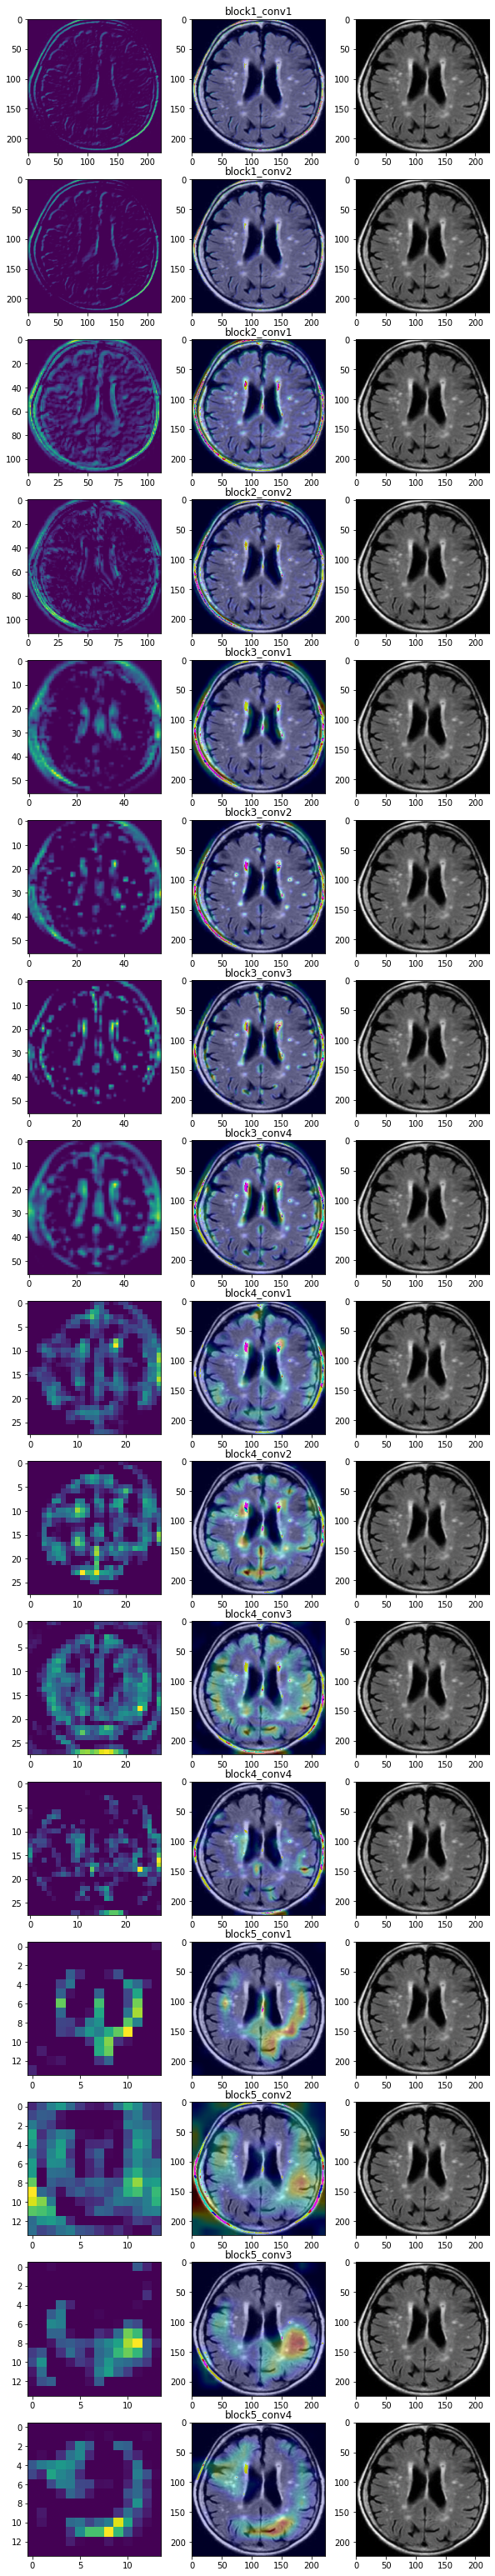

In [19]:
image, heatmap, superimposed_img = model.grad_cam(X_train[0], model.conv_layers)
plot_gradcam(image, heatmap, superimposed_img)

Plot gradcams

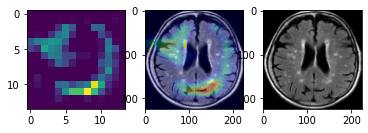

In [20]:
image, heatmap, superimposed_img = model.grad_cam(X_train[0])
plot_gradcam(image, heatmap, superimposed_img)

In [21]:
import seaborn as sns

def crcm(model, x, y):
    y_pred = model.predict(x)
    y_pred = [np.argmax(pred) for pred in y_pred]
    # y_pred = CLASSES[np.argmax()]
    # y_pred = np.asarray(y_pred)
    # y_pred = np.uint8(y_pred+0.5)
    cm = confusion_matrix(y, y_pred)
    CLASSNAMES = list(CLASSES.values())
    cr = classification_report(y, y_pred, target_names=CLASSNAMES)
    plt.xlabel('Pred')
    s = sns.heatmap(cm, vmin=0, annot=True, xticklabels=CLASSNAMES, yticklabels=CLASSNAMES)
    s.set(xlabel='Pred', ylabel='Actual')
    print(cr)

              precision    recall  f1-score   support

          no       0.40      0.89      0.55        18
         yes       0.00      0.00      0.00        24

    accuracy                           0.38        42
   macro avg       0.20      0.44      0.28        42
weighted avg       0.17      0.38      0.24        42



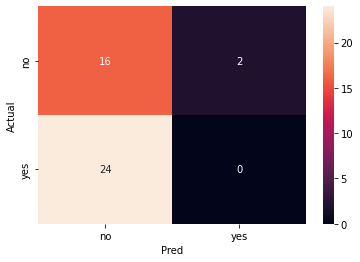

In [22]:
crcm(model, X_val, y_val)

Train with wandb

In [23]:
# callbacks = [earlystopper]
callbacks = [model_checkpoint_callback]

# Train
# model.train(callbacks=callbacks, verbose=2, wb=True)
model.transfer_learning(callbacks=callbacks, verbose=2, wb=True)
model.model.summary()


Epoch 1/100
32/32 - 5s - loss: 0.7240 - accuracy: 0.6640 - categorical_crossentropy: 0.7240 - val_loss: 0.6803 - val_accuracy: 0.6429 - val_categorical_crossentropy: 0.6803 - 5s/epoch - 158ms/step
Epoch 2/100
32/32 - 2s - loss: 0.4082 - accuracy: 0.8160 - categorical_crossentropy: 0.4082 - val_loss: 0.4317 - val_accuracy: 0.7619 - val_categorical_crossentropy: 0.4317 - 2s/epoch - 66ms/step
Epoch 3/100
32/32 - 2s - loss: 0.3273 - accuracy: 0.8560 - categorical_crossentropy: 0.3273 - val_loss: 0.4983 - val_accuracy: 0.7619 - val_categorical_crossentropy: 0.4983 - 2s/epoch - 55ms/step
Epoch 4/100
32/32 - 2s - loss: 0.2707 - accuracy: 0.8880 - categorical_crossentropy: 0.2707 - val_loss: 0.5130 - val_accuracy: 0.7619 - val_categorical_crossentropy: 0.5130 - 2s/epoch - 55ms/step
Epoch 5/100
32/32 - 2s - loss: 0.1894 - accuracy: 0.9440 - categorical_crossentropy: 0.1894 - val_loss: 0.3186 - val_accuracy: 0.9048 - val_categorical_crossentropy: 0.3186 - 2s/epoch - 68ms/step
Epoch 6/100
32/32 -

In [24]:
model.model.load_weights(f'model_checkpoint/{model_filename}')

              precision    recall  f1-score   support

          no       0.95      1.00      0.97        18
         yes       1.00      0.96      0.98        24

    accuracy                           0.98        42
   macro avg       0.97      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



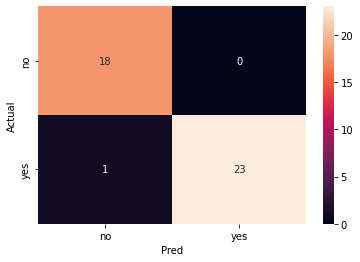

In [25]:
crcm(model, X_val, y_val)

In [26]:
model.model.save(f'model_checkpoint/model_{model_filename}')

'yes'

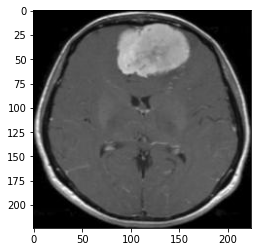

In [27]:
pic = X_train[55]
pred = model.predict(pic)
plt.imshow(pic)
CLASSES[np.argmax(pred[0])]

In [28]:
callbacks = [model_checkpoint_callback]
model.fine_tune(callbacks=callbacks, verbose=2, wb=True)
model.model.summary()

Epoch 1/10
32/32 - 9s - loss: 2.5285 - accuracy: 0.5760 - categorical_crossentropy: 2.5285 - val_loss: 1.3065 - val_accuracy: 0.4286 - val_categorical_crossentropy: 1.3065 - 9s/epoch - 277ms/step
Epoch 2/10
32/32 - 4s - loss: 0.6470 - accuracy: 0.7600 - categorical_crossentropy: 0.6470 - val_loss: 0.8133 - val_accuracy: 0.5714 - val_categorical_crossentropy: 0.8133 - 4s/epoch - 140ms/step
Epoch 3/10
32/32 - 5s - loss: 0.5988 - accuracy: 0.7120 - categorical_crossentropy: 0.5988 - val_loss: 0.9725 - val_accuracy: 0.5476 - val_categorical_crossentropy: 0.9725 - 5s/epoch - 143ms/step
Epoch 4/10
32/32 - 5s - loss: 0.4060 - accuracy: 0.8160 - categorical_crossentropy: 0.4060 - val_loss: 0.3575 - val_accuracy: 0.8571 - val_categorical_crossentropy: 0.3575 - 5s/epoch - 141ms/step
Epoch 5/10
32/32 - 4s - loss: 0.3179 - accuracy: 0.9440 - categorical_crossentropy: 0.3179 - val_loss: 0.3650 - val_accuracy: 0.8810 - val_categorical_crossentropy: 0.3650 - 4s/epoch - 138ms/step
Epoch 6/10
32/32 - 4

              precision    recall  f1-score   support

          no       0.95      1.00      0.97        18
         yes       1.00      0.96      0.98        24

    accuracy                           0.98        42
   macro avg       0.97      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



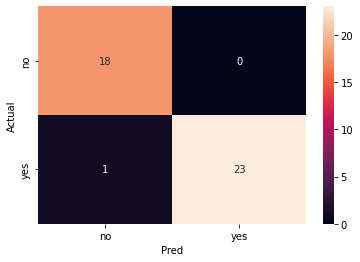

In [29]:
model.model.load_weights(f'model_checkpoint/{model_filename}')
crcm(model, X_val, y_val)


In [30]:
if RunningInCOLAB:
  from google.colab import drive
  drive.mount('/content/drive/')

  !cp '{model_filename}' "/content/drive/MyDrive/model"